# Rossmann Store Sales Forecasting
**Business Analytics (Spring, 2017)**  
서한빈(석사2) @ Data Science, Seoultech  

Submit Date: 2017.3.8.
* * *

## 0. Problem
### 유럽의 올리브영이라는 드럭스토어 Rossmann 매출 예측 문제
Kaggle Competition
> - 매장 관리자는 일일 판매량을 최대 6주전에 알아야 한다고 한다.
> - 따라서 1115개의 독일에 위치한 매장에 한정해서, 6주간의 일일 판매량을 예측하는게 원래 문제!  

In BA Class  
> - 예측범위를 대폭 축소해서 10개의 매장(Store ID: 1~10)에 대해 1주일 간의 일일 판매량을 예측하고 평가
> - 즉, 2014.1.1 부터 1주일간의 일일 판매량을 예측
> - 한편, 2013.1.1 부터 2013.12.31 까지의 데이터를 학습해 모델 학습(train)  

### Assignment's Problem
1. Which data mining algorithms are appropriate for this problem?
2. How do we make train data set to predict sales of the store?
3. Build your own model; and then Evaluate accuracy of your model
4. Summarize answers as slide; at this slide.  
* * *

## 1. Which data mining algorithms are appropriate for this problem?

### 목적에 따른 모델링 분류

#### Predictive modeling  
- `과거`의 데이터를 바탕으로 `미래`를 예측하는 것이 목적  
- 학습데이터에 입력(input)과 출력(output)이 갖춰야 있어야 하며, **교사학습(supervised learning)**이라 불림  
> - Nominal(Categorical) 변수를 출력할 때 Classification(분류) 문제   
> - Interval(Continuous) 변수를 출력할 때 **Prediction(예측)** 문제  

#### Descriptive modeling  
- `과거`의 데이터를 바탕으로 의미 있는 _결과(본질적 특성)_를 **`finding`** 하는 것이 목적
- 학습데이터에는 입력(input)만 갖춤. **비교사학습(un-supervised learning)**이라 불림
> - 비교사학습에는 군집화, 밀도추정, 차원축소 등 결과의 정답이 없다는 게 특징

### 예측 알고리즘
이 문제는 매출(Sales) 데이터를 예측하는 것이 목적이다.  
매출 데이터는 numeric 하기 때문에 **예측(prediction) 문제**.  
  
예측문제에 적용해 볼 수 있는 알고리즘으로 아래의 방법론을 생각해 보았다.
> * 회귀분석(Regression)  
> * 시계열예측(Time series forecasting)  
> * decision tree, knn-regression 등 기존 분류기법을 예측에 활용하는 방법 고려  
> * 분류기법과 예측기법을 혼용하는 앙상블(Ensemble) 기법 등  

 
유감이지만 `이 문제에서 어떤 알고리즘을 적절할까`에 대한 명쾌한 답은 이 단계에서 내릴 수 없을 것 같다.  
먼저 데이터가 어떻게 구성되어 있는지 먼저 살펴보고 생각해 봐야겠다.  
* * *

## 2. How do we make train data set to predict sales of the store?

### 2.1 데이터셋 셋팅
먼저 과제에서 제시한 데이터셋을 만들어야 한다.  
1. 파일을 불러온다.
2. train.csv 와 store.csv를 사용해 1부터 10까지의 스토어만 뽑고, 나머지는 버린다.

In [1]:
import pandas as pd
from pandas import DataFrame as df

f_dir = "D:/course_2017_spring/BA/Data/W1_Rossmann/"
dfTrain = pd.read_csv(f_dir+"train.csv")
dfStore = pd.read_csv(f_dir+"store.csv")
print(">> raw shape: ", dfTrain.shape, dfStore.shape)

## take stores from 1 to 10 only
print(">> feature names: ", dfTrain.keys()) 
dfTrain = dfTrain[dfTrain['Store']<11]
dfStore = dfStore[dfStore['Store']<11]
print(">> truncated shape: ", dfTrain.shape, dfStore.shape)

>> raw shape:  (1017209, 9) (1115, 10)
>> feature names:  Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')
>> truncated shape:  (9420, 9) (10, 10)


C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


  
** Store Id 값을 기준으로 1~10인 매장의 데이터만 추출한거다.**  
이제 날짜 정보를 기준으로 데이터셋을 `split` 해야한다.  
* `train` 데이터셋: 2013.1.1 ~ 2013.12.31  
* `test` 데이터셋: 2014.1.1 ~ 2014.1.7  

이를 위해서 아래 스탭으로 처리했다.
1. 그 다음으로 `str` 타입의 날짜정보(**Date**)를 시계열로 처리하기 위해서 **`datetime`** 타입으로 변환해야 한다.
2. 이제 날짜를 기준으로 최종적으로 `train` 데이터셋과 `test` 데이터셋을 분활한다.

In [2]:
## convert to datetime type from string type 'Date' 
from datetime import datetime as dt
tmp_idx = list(dfTrain.index.values)
dt_date = [dt.strptime(dfTrain['Date'][idx], '%Y-%m-%d') for idx in tmp_idx]
dfTrain['dt_date'] = pd.Series(dt_date, index=tmp_idx)
print(">> added shape: ", dfTrain.shape, dfStore.shape)

## build dataset
print(dfTrain['dt_date'].min()) # 2013-01-01 00:00:00
D_train = dfTrain[dfTrain['dt_date']<=dt(2013,12,31)]
D_test = dfTrain[dfTrain['dt_date']<=dt(2014,1,7)][dfTrain['dt_date']>dt(2013,12,31)]
print(">> train shape: {0}, test shape: {1}".format(D_train.shape, D_test.shape))

>> added shape:  (9420, 10) (10, 10)
2013-01-01 00:00:00
>> train shape: (3650, 10), test shape: (70, 10)


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### 2.2 데이터 탐색
#### 2.2.1 target 데이터 탐색
먼저 매출(**Sales**) 데이터의 분포를 보자. 이때, 기초통계량(`describe()`)이랑 `boxplot`을 보면 좋을꺼 같다.

In [3]:
D_train['Sales'].describe()

count     3650.000000
mean      5153.097534
std       3160.981926
min          0.000000
25%       3773.000000
50%       5250.500000
75%       7072.000000
max      18413.000000
Name: Sales, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x24553364ac8>],
 'caps': [<matplotlib.lines.Line2D at 0x2455336fe48>,
 'fliers': [<matplotlib.lines.Line2D at 0x24553382e10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2455337ceb8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x24553364c88>,
  <matplotlib.lines.Line2D at 0x2455336fd30>]}

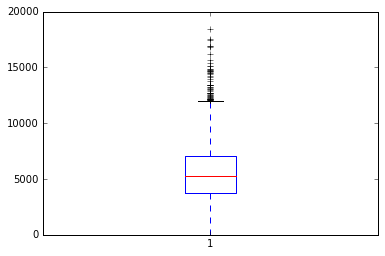

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.boxplot(np.array(D_train['Sales']))

** 뭔가 이상하다! **
기초통계량과 `boxplot`을 살펴보면서, 이상하다고 느낌점이 매출이 0인 날이였다.   
그래서 `histogram`을 그려보았다. 간격은 1000으로 주었다.

(array([ 619.,   34.,  118.,  263.,  617.,  640.,  418.,  321.,  243.,
         170.,   95.,   48.,   28.,   12.,   13.,    4.,    4.,    2.,    1.]),
 array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000]),
 <a list of 19 Patch objects>)

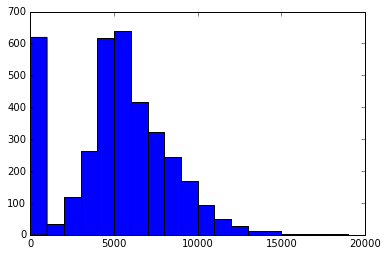

In [5]:
bins_range = range(D_train['Sales'].min(), D_train['Sales'].max()+1000,1000)
plt.hist(D_train['Sales'], bins=bins_range)

**매출이 0인 날이 다수 존재하는 것으로 보인다!**  
매출이 0인날과 아닌날의 가장 큰 영향을 끼치는 변수가 무엇일까 찾아보았다.

> 이때, 상식적으로 생각해봤을 때 영업을 안하는 날에는 당연히 매출이 없을꺼라 생각했다.  
영엽여부를 나타내는 변수(**Open**)를 기준으로 `histogram`을 다시 그려볼 수 있었다.

Ttest_indResult(statistic=-65.823045951019111, pvalue=0.0)

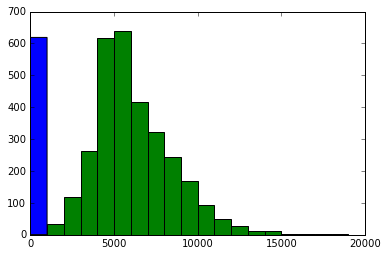

In [6]:
plt.hist(D_train[D_train['Open']==0]['Sales'], bins=bins_range)
plt.hist(D_train[D_train['Open']==1]['Sales'], bins=bins_range)

from scipy import stats
stats.ttest_ind(D_train[D_train['Open']==0]['Sales'],D_train[D_train['Open']==1]['Sales'])

** 명쾌하게 두 집단이 분리되는걸 확인할 수 있다! **  
t-test를 이용해 확인해 보았을 때도 p-value가 0에 수렴하는 것으로 보인다.  
그렇다면 이제 `Open==0`인 데이터는 제외하고, `Open==1`인 데이터에 한정해 살펴보아야겠다. 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


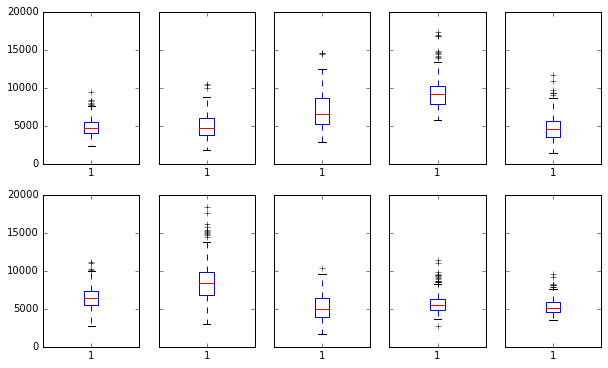

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6), sharey=True)
tmp_idx = 0
for store in set(D_train['Store']) :
    #print("Store {0}\n".format(store) ,D_train[D_train['Open']==1][D_train['Store']==store]['Sales'].describe())
    if tmp_idx < 5:
        axes[0,tmp_idx].boxplot(np.array(D_train[D_train['Open']==1][D_train['Store']==store]['Sales']))
    else :
        axes[1,tmp_idx-5].boxplot(np.array(D_train[D_train['Open']==1][D_train['Store']==store]['Sales']))
    tmp_idx += 1

** 각 매장별로 영업일(`open==1`)의 매출분포를 `boxplot`으로 표현했다! **  
각 매장의 특성에 따라 매출분포가 상이할 것이라는 판단할 수 있다.  
다행히 매장의 특성정보를 제공하는 데이터셋 `dfStore`가 함께 주어졌다.  

근데 문제는 현재 매출정보가 있는 테이블은 `dfTrain`을 변형해서 만든 `D_train`을 보고 있다.  
(그리고 그 중에서 `Open==1`을 만족하는 record 만 고려하고 있다.)  
우리는 이걸 함께보기 위해서 테이블을 **join** 해야하는데, 이번 기회에 `Open==0`인 record도 함께 날려버리자.  
  
그렇게해서 **`다중회귀분석(Multiple linear regression)`**을 적용해보는 것으로 계획을 세워야 겠다.
더 많은 변수들의 관계를 살펴보아야 겠지만, 초벌?분석이기 때문에 이쯤에서 미뤄두고 일단 모델링을 하는데 초점을 맞추도록 하겠다.
  
### 2.3 데이터 조인
`D_train` 테이블과 `dfStore` 테이블의 공통된 `key`는 **Store** Id 이다.  
데이터베이스 조인기능을 `pandas`에서 어떻게 시킬 수 있을까에 대해 구글링을 해보았다.  
[pandas.DataFrame.merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) 함수를 이용하면 가능하다고 한다.


In [8]:
print(dfStore)

   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   
5      6         a          a                310.0                       12.0   
6      7         a          c              24000.0                        4.0   
7      8         a          a               7520.0                       10.0   
8      9         a          c               2030.0                        8.0   
9     10         a          a               3160.0                        9.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0

** 불필요 변수 지우기 **  
`dfStore` 테이블은 각 매장에 대한 정보여서 크기가 크지 않아 열어보고 확인했다.  
`Promo2SinceWeek,  Promo2SinceYear, PromoInterval` 변수는 의미도 잘 와닿지 않고 데이터도 지저분해 보여서  
*임의로* 지워야 겠다고 판단했다.  

또, 논리적으로 이상한 부분을 발견했다.
* `CompetitionDistance` : 각 매장에서 경쟁업체 매장과의 거리정보. 인데...
* `CompetitionOpenSinceMonth, CompetitionOpenSinceYear`: 그 경쟁업체가 언제 개점했는지에 대한 정보.  

현재 우리가 학습하고 예측하고자 하는 기간의 범위는 2013년 한해동안의 데이터를 활용하는 것인데,  
그보다 미래에 오픈하게 되는 경쟁업체의 정보가 들어있다. 애매하니까 다 지워버리자.



1. `merge` 함수를 이용해 `D_train_join` 테이블을 만든다.
2. 각 속성의 어떤 값을 가지고 있는지 확인한다. 
> 이때 날짜정보(Date, dt_date), 방문고객수(Customer)정보는 생략한다.  
`D_train` 테이블에 있던 변수라서 너무 많다는게 변명인데, 사실 확인해보는게 무의미.  
categorical한 변수에서 어떤 변수들이 있는지를 확인하기 위해서 해보는거다.  
몰론 타겟변수인 Sales 변수도 포함.

In [9]:
print(dfStore.keys())
for key in ['Promo2SinceWeek','Promo2SinceYear','PromoInterval'] :
    del dfStore[key]
for key in ['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear'] :
    del dfStore[key]

    
Jtrain = pd.merge(D_train, dfStore, on='Store')
Jtest = pd.merge(D_test, dfStore, on='Store')
for key in Jtrain.keys() :
    if key in ['Sales', 'Customers', 'Date', 'dt_date'] :
        print("{0} \t pass...".format(key))
        continue
    print("{0}\t{1}".format(key, set(Jtrain[key])))

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Store	{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
DayOfWeek	{1, 2, 3, 4, 5, 6, 7}
Date 	 pass...
Sales 	 pass...
Customers 	 pass...
Open	{0, 1}
Promo	{0, 1}
StateHoliday	{'b', 'c', 'a', '0'}
SchoolHoliday	{0, 1}
dt_date 	 pass...
StoreType	{'a', 'c'}
Assortment	{'a', 'c'}
Promo2	{0, 1}


** 이쯤에서 변수를 정리해보자. **  
먼저 스킵했던 변수  
1. `Date` : 날짜정보인데, `str` 타입의 변수다. 쓸모없다.(그래서 미리 `datetime` 타입으로 바꿔뒀다!)
2. `dt_date` : 같은 날짜정보. 근데 `datetime` 타입. 조금 쓸모있다고 생각되는데, 이게 MLR에서 input 변수로 받아들여질지 모르겠다. 안되면 정렬해서 index화해서 사용하면 될 꺼 같다.
3.  `Customer` : 일일 방문고객수. 정수형(`int`) 변수여서 아주 좋다.

이제 `set()`을 이용해 카테고리를 확인해보았던 변수
1. `Store, DayOfWeek, Open, Promo, SchoolHoliday, Promo2` : 값만 정수지 사실 명목변수다.  
2. `StateHoliday, StoreType, Assortment` : 심지어 값이 `str` 타입인 명목변수다.  
이 변수들은 모두 **dummy coding** 해야한다.
> `dummy coding`은 `1-of-c coding` 이라고도 하는데,  
N(>3)개의 값을 갖는 명목변수라고 할 때  N-1개의 가변수를 만들고 값들을 모두 `binary` 값으로 치환해주는 작업이다. 이걸 하는 이유는 명목변수는 수학적인 모델링이 불가능하기 때문  

정말 다행인 점은 10개의 매장정보만 추려오면서 특정 명목변수에서 2개의 결과만 남는 경우도 있었다.
StoreType 와 Assortment 라는 변수인데 그 외에 원래 `binary` 값을 갖는 변수도 몇몇 있다.

### 2.4 명목변수 더미코딩(dummy coding)
pandas에서 테이블 조인하는것과 동일하게 개념적으로만 이렇게 해야한다고만 알고있고, 실제로 더미코딩을 해본 적이 없다.  
그래서 구글에다가 `pandas dummy coding` 이라고 검색하니까 도큐먼트를 쉽게 찾을 수 있었다.  
[pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)를 참고해서 dummy coding을 해봤다.

1. 이제 target 변수를 split 할때가 됬다. Sales 변수만 빼서 y라고 하자.
2. ~~나머지 변수는 이제 input 변수니까 X라고 하자.~~
2. 아니 그 전에 `str` 타입으로 되어 있는 명목변수를 `int` 타입으로 변환해야 한다.


In [10]:
y_train, y_test = Jtrain['Sales'], Jtest['Sales']
del Jtrain['Sales']
del Jtest['Sales']
X_train, X_test = None, None

replace_dic = {'StateHoliday':['0', 'a', 'b', 'c'], 'StoreType':['a', 'c'], 'Assortment':['a', 'c']}
def replace_str2int(df, key) :
    tmp_li = []
    for idx in df.index.values :
        tmp_li.append(replace_dic[key].index(df[key][idx]))
    return tmp_li            
for key in replace_dic.keys() :
    Jtrain[key] = replace_str2int(Jtrain, key)
    Jtest[key] = replace_str2int(Jtest, key)
    
for key in Jtrain.keys() :
    if key in ['Sales', 'Customers', 'Date', 'dt_date'] :
        print("{0} \t pass...".format(key))
        continue
    print("{0}\t{1}".format(key, set(Jtrain[key])))

Store	{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
DayOfWeek	{1, 2, 3, 4, 5, 6, 7}
Date 	 pass...
Customers 	 pass...
Open	{0, 1}
Promo	{0, 1}
StateHoliday	{0, 1, 2, 3}
SchoolHoliday	{0, 1}
dt_date 	 pass...
StoreType	{0, 1}
Assortment	{0, 1}
Promo2	{0, 1}


** `str` 타입의 명목변수가 `int` 타입으로 모두 변환된 것을 확인 **  
이제 진짜 dummy coding을 할 수 있다. ~~결과를 바로 X 라고 하자.~~ ㅠㅠ

In [11]:
## X_train, X_test

## 3. Build your own model; and then Evaluate accuracy of your model
시간 관계상 모델링 작업까지 마치지 못했다.